In [1]:
import sys
sys.path.insert(0, "..")

import torch
import torch.nn as nn
from src.utils.provider import Provider, DictProvider
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

In [2]:
t = np.asarray([2.0])
t

array([2.])

In [3]:
t[0] = 3.0
t

array([3.])

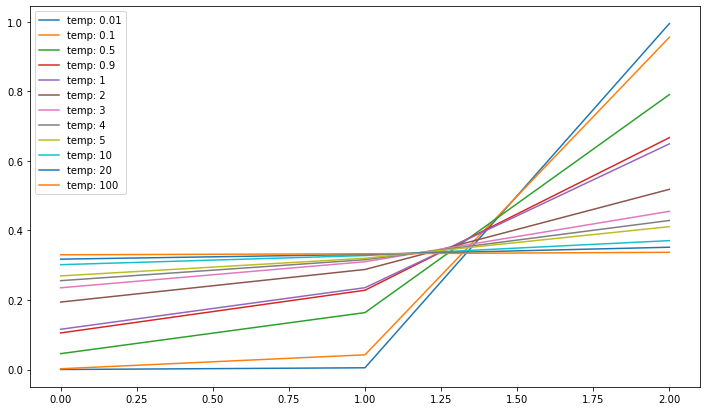

In [27]:
# show gumbel softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

plt.figure(figsize=(12, 7))

for t in temp:
    data = F.gumbel_softmax(torch.ones((q, n)), tau=np.array(t)).sort(dim=-1).values.mean(dim=0)
    plt.plot(np.arange(n), data)

plt.legend([f'temp: {t}' for t in temp])
# plt.yscale('log')

# Anything above temp 20 is useless
# use tanh decay from temp 20 -> 0.1

In [5]:
ip = torch.zeros((1, 3, 32, 32)).to('cuda')
ip2 = torch.zeros((1, 1)).to('cuda')

In [6]:
from src.torchmodules.sr3_diffusion.unet_attention import UNetWithAttention

m = UNetWithAttention(out_channels=3)
m = m.to('cuda')

# m(ip, ip2)

summary(m, input_data=(ip, ip2))

/opt/conda/envs/mtpignite/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                                   Output Shape              Param #
UNetWithAttention                                                                                                                                                                                                                                                                                                                                                        --                        --
├─BufferDict: 1-1                                                                                                                                                                                                      

In [7]:
next(m.parameters()).device

device(type='cuda', index=0)

In [8]:
m.forward_measurements({'flops': torch.zeros((1)).to('cuda')})

  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcde,abcfg->abdefg
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop count:  1.311e+05
  complete contraction:  abcdef,abgef->abgcd
         naive scaling:  7
     optimized scaling:  7
      naive flop count:  1.311e+05
  optimized flop coun

{'flops': tensor([2.8938e+17], device='cuda:0')}

In [9]:
from src.torchmodules.sr3_diffusion.unet_attention import UNetWithAttentionSupernet

def mask_to_first(ops):
    for name, op in ops.items():
        op.operation_mask.fill_(False)
        op.operation_mask[0] = True

m = UNetWithAttentionSupernet(
    out_channels=3,
    subnet_mask_fn=mask_to_first,
)
m = m.to("cuda")

m(ip, ip2)

summary(m, input_data=(ip, ip2))


Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                                                  Output Shape              Param #
UNetWithAttentionSupernet                                                                                                                                                                                                                                                                                                                                                               --                        --
├─MeasurableSequential: 1                                                                                                                                                                

In [10]:
multi = list(m._TrackedMultiOperationModules.keys())
print(len(multi))
# multi

91


['net/module/unet_layer_down/res_block/block1/block/3',
 'net/module/unet_layer_down/res_block/block2/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_down/res_block/block1/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_down/res_block/block2/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_down/res_block/block1/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_down/res_block/block2/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_down/res_block/block1/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_down/res_block/block2/block/3',
 'net/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_child/0/module/unet_layer_down/res_block/block1/block/3',
 '

In [11]:
sub = m.current_subnet()

In [12]:
summary(sub, input_data=(ip, ip2))

Layer (type:depth-idx)                                                                                                                                                                                                                                                                                                                                                   Output Shape              Param #
UNetWithAttentionSupernet                                                                                                                                                                                                                                                                                                                                                --                        --
├─Module: 1                                                                                                                                                                                                            

In [13]:
# _=sub.load_state_dict(m.state_dict(), strict=False)

In [14]:
with m.subnet_masked():
    op1 = m(ip, ip2)
    op1_1 = m(ip, ip2)
    op2 = sub(ip, ip2)

print(f'  op1 == op2 ', (op1 == op2).all())
print(f'| op1 - op2 |', (op1-op2).abs().max())
print(f'| op1 - op2 |', (op1-op2).abs().mean())

print()

print(f'  op1 == op1_1 ', (op1 == op1_1).all())
print(f'| op1 - op1_1 |', (op1-op1_1).abs().max())
print(f'| op1 - op1_1 |', (op1-op1_1).abs().mean())

  op1 == op2  tensor(True, device='cuda:0')
| op1 - op2 | tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
| op1 - op2 | tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

  op1 == op1_1  tensor(True, device='cuda:0')
| op1 - op1_1 | tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
| op1 - op1_1 | tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


In [15]:
op1, op2, op1_1

(tensor([[[[-0.8636, -0.6901,  0.5563,  ...,  0.0055,  0.0122,  0.4377],
           [-0.1843, -0.9288,  0.4431,  ...,  0.1528,  0.1900,  0.2071],
           [-0.4607, -0.9567, -0.5888,  ..., -0.2645, -0.1985, -0.0864],
           ...,
           [-0.7961, -0.0242, -0.5932,  ...,  0.0641,  0.0570,  0.1618],
           [-0.7520, -0.0160, -0.4275,  ...,  0.0618,  0.0470,  0.1535],
           [-0.0189, -0.4286, -0.2146,  ...,  0.0406,  0.0406,  0.0958]],
 
          [[-0.8416,  0.9887,  0.9289,  ...,  0.1713,  0.3146,  0.1851],
           [-0.3079,  0.9707,  1.2026,  ...,  0.1662, -0.0171, -0.3363],
           [-0.1670,  1.1922,  0.1735,  ..., -0.3995, -0.3965, -0.4576],
           ...,
           [-0.4469, -0.9970, -0.4177,  ..., -0.2876, -0.3011, -0.0915],
           [-0.5496, -1.0467, -0.6051,  ..., -0.2778, -0.2930, -0.1061],
           [-0.4045, -0.3176, -0.2178,  ..., -0.2475, -0.2483, -0.1046]],
 
          [[ 2.9196,  1.5753,  1.1253,  ...,  0.7195,  0.5480,  0.2820],
           [ 